In [32]:
import re
import random
import pandas as pd
import hashlib

In [ ]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [34]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
OAuth 2.0 RFC6749,100.391428,9.126493,13.311349,11
pfSense,141.179352,11.764946,17.896006,12
Accounting,156.184377,9.187316,14.499083,17
Pandas,161.691658,53.897219,62.106179,3
"The Starless Crown, Rollins",196.769442,7.287757,13.388756,27
Python + Oauth2.0,484.408779,21.061251,34.054496,23
Azure Files Documentation,610.110147,19.065942,38.320706,32
Azure DevOps Pipelines,678.119783,113.019964,182.613478,6
Azure Developer Associate,738.648673,92.331084,299.163041,8
Terraform,1042.897056,104.289706,227.052988,10


# Histogram

sum of ages: ~50779.00


<Axes: >

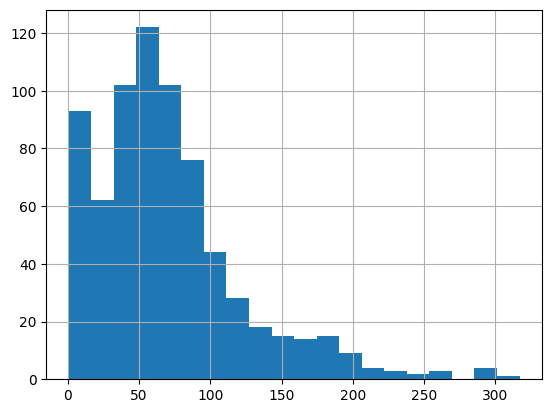

In [35]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~50779.00


<Axes: >

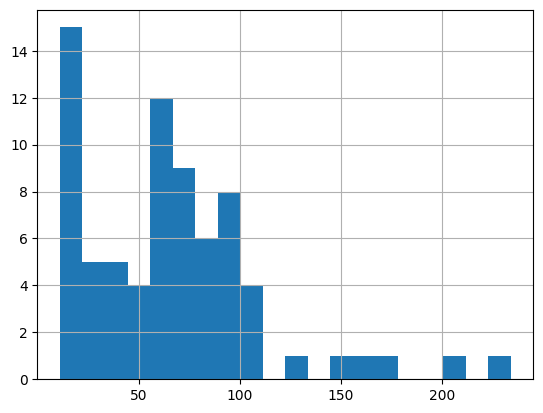

In [47]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='JavaScript Concepts']['age'].hist(bins=20)

# Completely Random Shuffle

In [37]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [38]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [39]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [40]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [41]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [42]:
n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 717
Total card age: 50779.00


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
197,Pandas,How can you apply multiple aggregation functio...,97c849b0662c13306e30c1cf72bf4b71,62.106179,53.897219,-62.106179,161.691658,0.990203,3,0,0,-62.106179
440,Pandas,How can you fill missing values using interpol...,0609082bc5641984a4d23b1a31895977,57.398559,53.897219,-62.106179,161.691658,0.990203,3,1,0,-57.398559
678,Pandas,What does the unstack() function do in Pandas?...,b8084faaad69ecd8e1b703c79b8f63e7,42.186919,53.897219,-62.106179,161.691658,0.990203,3,2,0,-42.186919
136,Azure DevOps Pipelines,How can you pass secrets securely in Azure Dev...,5b00153ed3bdf8955aa08ad4e2779a5c,182.613478,113.019964,-182.613478,678.119783,0.075743,6,0,0,-182.613478
380,Azure DevOps Pipelines,What is the default trigger for a YAML-based p...,944cd0a101c4cff672ef88ce12f5481b,135.373631,113.019964,-182.613478,678.119783,0.075743,6,1,0,-135.373631
620,Azure DevOps Pipelines,What is the purpose of the 'checkout' step in ...,310440cab075b3f43f9076075e30909c,98.519345,113.019964,-182.613478,678.119783,0.075743,6,2,0,-98.519345
137,Azure DevOps Pipelines,How can you trigger a pipeline based on a Git ...,ec5fd89b3d2e992bc3261784a00f628b,94.369682,113.019964,-182.613478,678.119783,0.075743,6,3,0,-94.369682
240,Azure Developer Associate,"Q: In Azure Storage, which feature allows revo...",b18514066eebd7faf9c8ac3843d058c0,299.163041,92.331084,-299.163041,738.648673,0.004831,8,0,0,-299.163041
483,Azure Developer Associate,"Q: In Azure Storage, which SAS type supports A...",acc732a94ac050d591b553ecd920f65e,244.518084,92.331084,-299.163041,738.648673,0.004831,8,1,0,-244.518084
241,Azure Developer Associate,App Configuration doesn't version key values a...,c5b1da2f26c3dc2ad56cbaba6c51b9ed,176.752030,92.331084,-299.163041,738.648673,0.004831,8,2,0,-176.752030



## Random

In [43]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [44]:
existing_cards.head(10)['age'].sum()

np.float64(1393.000948574881)

In [45]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
12,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,317.047083,100.663559,-317.047083,1811.944070,0.199732,18,0,0,-317.047083
240,Azure Developer Associate,"Q: In Azure Storage, which feature allows revo...",b18514066eebd7faf9c8ac3843d058c0,299.163041,92.331084,-299.163041,738.648673,0.004831,8,0,0,-299.163041
244,Python,Q:\nHow can you define a custom exception in P...,42a1f83efefd4b56173827e48cae56f3,296.010861,89.284328,-296.010861,4196.363433,0.246790,47,0,0,-296.010861
18,Asynchronous Python,"Thread Pool Executor\nA thread pool executor, ...",102c628cf04ad4661a71d437cd297a11,292.273304,100.920690,-292.273304,2825.779333,0.796462,28,0,0,-292.273304
28,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,288.666252,92.678394,-288.666252,4541.241308,0.867091,49,0,0,-288.666252
45,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,258.438994,96.606762,-258.438994,3671.056975,0.879552,38,0,0,-258.438994
293,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,255.123516,96.606762,-258.438994,3671.056975,0.879552,38,1,0,-255.123516
58,VMWare,Type 1 Hypervisor\n\nA hypervisor that runs di...,69a3327d36d550a31995e37ddee2031e,254.877865,104.408446,-254.877865,3863.112518,0.966808,37,0,0,-254.877865
268,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,250.838853,100.920690,-292.273304,2825.779333,0.796462,28,1,0,-250.838853
483,Azure Developer Associate,"Q: In Azure Storage, which SAS type supports A...",acc732a94ac050d591b553ecd920f65e,244.518084,92.331084,-299.163041,738.648673,0.004831,8,1,0,-244.518084


In [46]:
existing_cards['age'].mean()

np.float64(70.8214780688208)